In [1]:
import numpy as np
import scipy.signal as sig
import soundfile as sf
import matplotlib.pyplot as plt


# From analog design to digital filter via bilinear transform 
## Example: Butterworth-design

First we design a function that solves 
$$ H(s)H(-s) = \frac{1}{1+C(s)C(-s)} $$

with $C(s) = 1 + (-1)^n C^2 s^{2n}$ as the Butterworth polynomial.
Only the poles on the left side of the complex plane $s = \sigma + j\omega$ are stable and used in the final design.

In [2]:
def compute_analog_butterworth(order, C=1):
    """This function computes the numerator = 1 and denominator of the analog system function H(s) = C(s)/D(s)
    for an analog butterworth prototype
    Input: 
        order: the order of the desired filter (integer)
        C: design parameter for the attenuation at the normalized frequency 1 (default C = 1 ≙ -3 dB)
    returns: d,c numerator d and denominator c of the transfer function polynomials in s
    example order = 2, C = 1 ==> d = [1 0 0], c = [1 sqrt(2) 1] """
    
    s_poly = [1]
    for count in range(2*order-1):
        s_poly.append(0)

    s_poly.append((-1)**order*C**2)
    s_poly = np.array(s_poly)

    roots_circle = np.roots(s_poly)
    # print(roots_circle)
    left_roots = roots_circle[np.real(roots_circle) <= 0]
    # print(left_roots)

    system_func_den = np.poly(left_roots)
    # print(system_func_den)
    d = 1
    c = system_func_den
    return d, c


## Filter specification

A digital butterworth lowpass filter is typically designed by two parameters, the cutoff frequency and the order. The natural cutoff frequency is at the -3 dB point of the transfer function.
Since we are in the digital domain, the sampling frequency is also necessary.


In [3]:
# define design parameter
f_cut = 5000
sampling_rate = 16000
filter_order = 2


## analog design and lowpass lowpass transformation
1. normalized butterworth design with $C = 1$ and $\omega = 1$
2. lowpass to lowpass transform

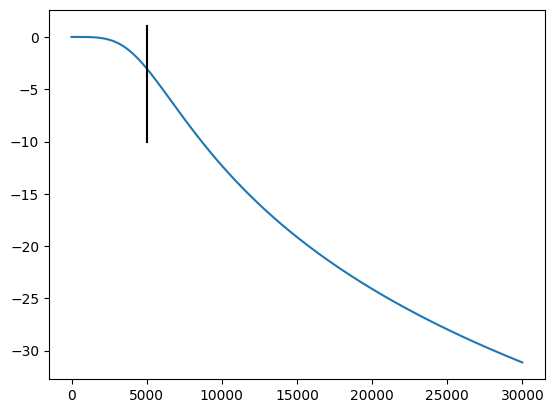

In [4]:
d_norm, c_norm = compute_analog_butterworth(filter_order)
d, c = sig.lp2lp(d_norm, c_norm, 2*np.pi*f_cut)
freq_vec = 2*np.pi*np.linspace(0, 30000, num=200)
w, tf = sig.freqs(d, c, freq_vec)
fig, ax = plt.subplots()
ax.plot(w/(2*np.pi), 20*np.log10(np.abs(tf)))
ax.plot([f_cut, f_cut], [-10, 1], 'k')


## analog to digital via bilinear transform
the bilinear transform maps the left side of the complex plane inside the unit circle and therefore keeps stable analog filter stable in the digital z-domain.
However, it squeezes the full frequency range from 0 to $\infty$ Hz in the range from 0 to $f_s/2$, where $f_s$ is the sampling rate.
This leads to a warped transfer function and the cut frequency is at the wrong frequency.

253


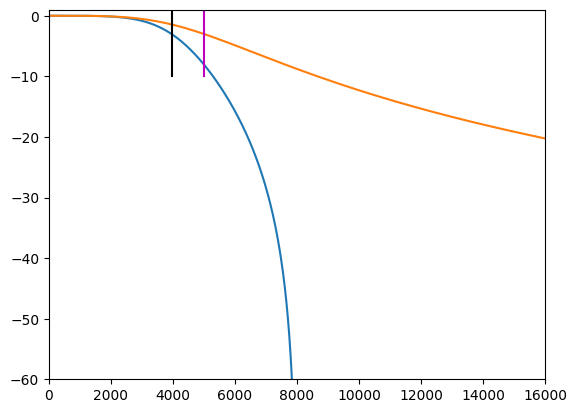

In [5]:
# small helper function from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array/2566508#2566508
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


b, a = sig.bilinear(d, c, sampling_rate)
w_dig, tf_dig = sig.freqz(b, a, fs=sampling_rate)
cut_index, value = find_nearest(20*np.log10(np.abs(tf_dig)), -3)
print(cut_index)

fig, ax = plt.subplots()
ax.plot(w_dig, 20*np.log10(np.abs(tf_dig)))
ax.plot(w/(2*np.pi), 20*np.log10(np.abs(tf)))
ax.plot([w_dig[cut_index], w_dig[cut_index]], [-10, 1], 'k')
ax.plot([f_cut, f_cut], [-10, 1], 'm')
ax.set_xlim((0, sampling_rate))
ax.set_ylim((-60, 1))
plt.show()


## Problems
1. the cutoff frequency is lower than expected
2. the lowpass is very steep towards $f_s/2$

## Solutions
The cutoff frequency can be adjusted by anticipating the bilinear transform in the analog design. This is called pre-warping. The steep response cannot be solved easily. A complete different design is necessary to mimic the real analog response. For example frequency domain least squares can be used to solve for better filter coefficients (out of scope here)

7622.150559616913


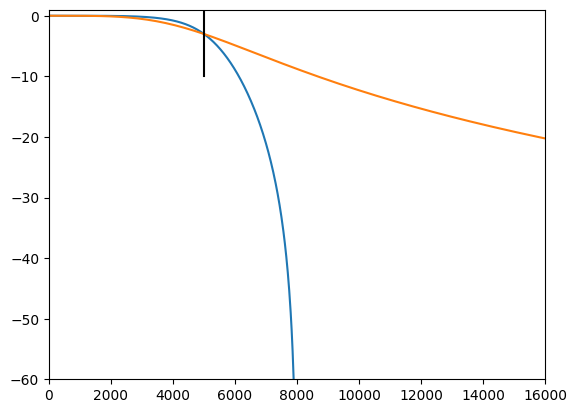

In [6]:
f_cut_warped = np.tan(np.pi * f_cut/sampling_rate) * sampling_rate/np.pi
print(f_cut_warped)
d, c = sig.lp2lp(d_norm, c_norm, 2*np.pi*f_cut_warped)
b, a = sig.bilinear(d, c, sampling_rate)
w_dig, tf_dig = sig.freqz(b, a, fs=sampling_rate)
cut_index, value = find_nearest(20*np.log10(np.abs(tf_dig)), -3)


fig, ax = plt.subplots()
ax.plot(w_dig, 20*np.log10(np.abs(tf_dig)))
ax.plot(w/(2*np.pi), 20*np.log10(np.abs(tf)))
ax.plot([w_dig[cut_index], w_dig[cut_index]], [-10, 1], 'k')
#ax.plot([f_cut, f_cut],[-10, 1],'m')
ax.set_xlim((0, sampling_rate))
ax.set_ylim((-60, 1))
plt.show()
